# Cài đặt các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
rcParams['figure.figsize'] = 10,6

#  Read file Web Trafic

In [2]:
raw_df = pd.read_csv('traffic.csv')
raw_df.head()

,Date,Visits
0,01-01-2020,1554.0
1,01-02-2020,2820.0
2,01-03-2020,2970.0
3,01-04-2020,2111.0
4,01-05-2020,2393.0


In [3]:
raw_df.tail()

,Date,Visits
1911,NaN,NaN
1912,NaN,NaN
1913,NaN,NaN
1914,NaN,NaN
1915,NaN,NaN


# Delete Mising Value and Outlier

In [4]:
raw_df['Date'].duplicated().sum()

1683

In [5]:
raw_df['Date'].isnull().sum()

1684

In [6]:
raw_df['Visits'].isnull().sum()

1684

In [7]:
notNull_df = raw_df.dropna()
notNull_df


,Date,Visits
0,01-01-2020,1554.0
1,01-02-2020,2820.0
2,01-03-2020,2970.0
3,01-04-2020,2111.0
4,01-05-2020,2393.0
...,...,...
227,8/15/2020,2221.0
228,8/16/2020,2724.0
229,8/17/2020,3456.0
230,8/18/2020,3581.0


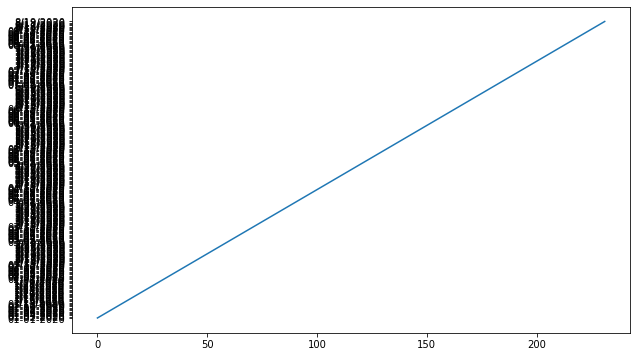

In [8]:
plt.plot(notNull_df['Date'])

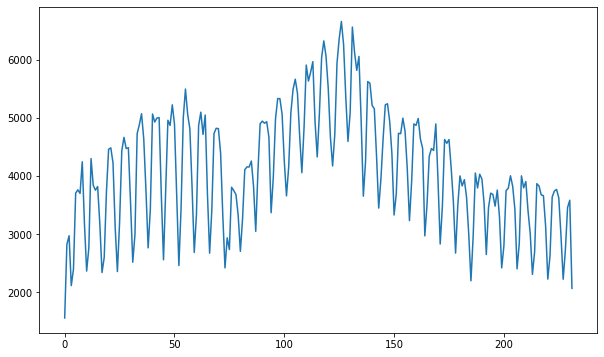

In [9]:
plt.plot(notNull_df['Visits'])

In [10]:
notNull_df['Date'] = pd.to_datetime(raw_df['Date'], infer_datetime_format=True)
indexed_df = notNull_df.set_index(['Date'])

C:\Users\HP\AppData\Local\Temp\ipykernel_8764\3922207586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notNull_df['Date'] = pd.to_datetime(raw_df['Date'], infer_datetime_format=True)


In [11]:
from datetime import datetime
indexed_df.head()

,Visits
Date,
2020-01-01,1554.0
2020-01-02,2820.0
2020-01-03,2970.0
2020-01-04,2111.0
2020-01-05,2393.0


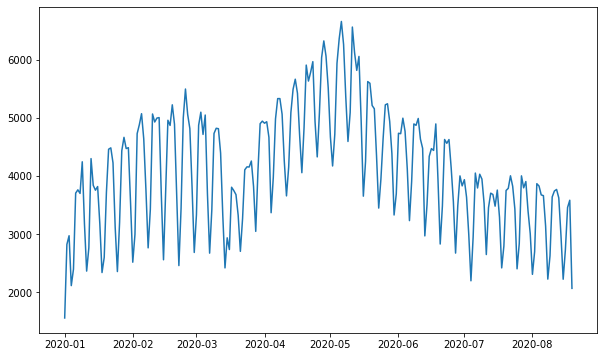

In [12]:
plt.plot(indexed_df)

## Normalization

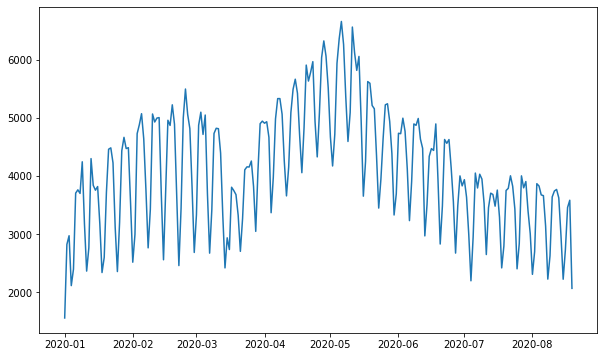

In [43]:
nor_df = indexed_df
plt.plot(nor_df)


## Split into Train set and Test set

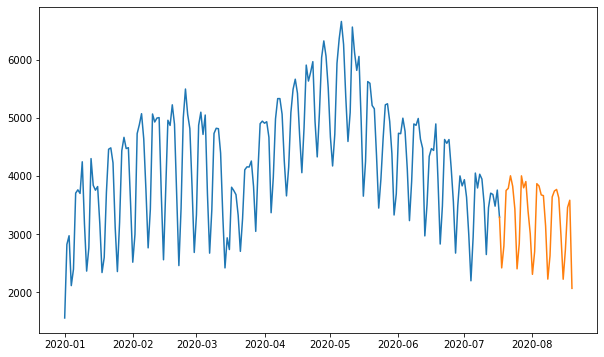

In [14]:
df_train = nor_df[:199].copy()
df_test = nor_df[198:].copy()
plt.plot(df_train)
plt.plot(df_test)

## Stationary

In [15]:
# Dickey Fuller Test

def perform_ad_fuller(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print("p-value: %f" % result[1])

perform_ad_fuller(df_train)

ADF Statistic: -1.503034
p-value: 0.532010


In [16]:
diff = df_train.diff().dropna()
perform_ad_fuller(diff)

ADF Statistic: -3.158744
p-value: 0.022500


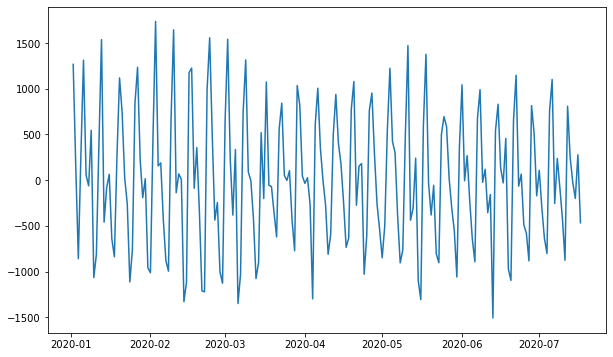

In [17]:
plt.plot(diff)

## Chose Model

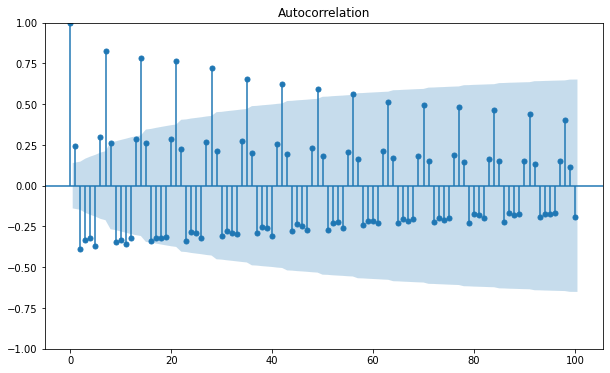

In [32]:
acf_plot = plot_acf(diff,lags=100)

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


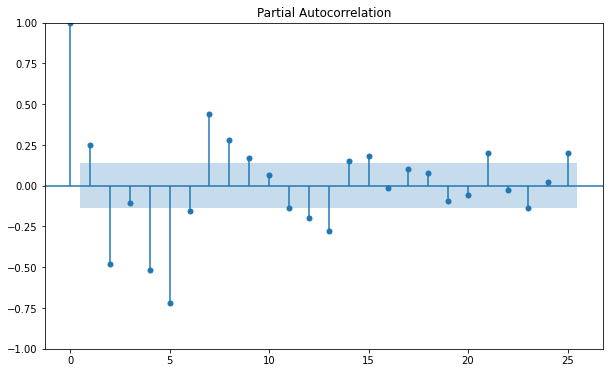

In [33]:
pacf_plot = plot_pacf(diff,lags=25)

Dua tren PACF, nen bat dau voi AR with lags 2,4,5,7

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# 1,2,0 ARIMA Model
model = ARIMA(diff, order=(7,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Visits   No. Observations:                  198
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -1435.477
Date:                Sun, 09 Apr 2023   AIC                           2886.955
Time:                        11:15:24   BIC                           2913.221
Sample:                    01-02-2020   HQIC                          2897.587
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0884      0.068    -15.930      0.000      -1.222      -0.955
ar.L2         -1.2363      0.076    -16.239      0.000      -1.386      -1.087
ar.L3         -1.1821      0.068    -17.303      0.0

In [38]:
#residuals = pd.DataFrame(model_fit.resid)
#fig, ax = plt.subplots(1,2)
#residuals.plot(title="Residuals", ax=ax[0])
#residuals.plot(kind='kde', title='Density', ax=ax[1])
#plt.show()

predictions = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
predictions

2020-07-17   -630.832403
2020-07-18   -556.362602
2020-07-19    441.717379
2020-07-20    487.160223
2020-07-21   -195.264249
2020-07-22    -71.606856
2020-07-23    164.929389
2020-07-24   -410.899128
2020-07-25   -479.459424
2020-07-26    375.864517
2020-07-27    453.501777
2020-07-28   -162.395214
2020-07-29    -75.039016
2020-07-30    125.612217
2020-07-31   -377.086002
2020-08-01   -417.735496
2020-08-02    330.762668
2020-08-03    412.825369
2020-08-04   -131.009760
2020-08-05    -76.759239
2020-08-06     88.891340
2020-08-07   -342.357877
2020-08-08   -367.425768
2020-08-09    294.044617
2020-08-10    374.764882
2020-08-11   -104.837309
2020-08-12    -77.497252
2020-08-13     57.669643
2020-08-14   -311.079514
2020-08-15   -323.389825
2020-08-16    262.041201
2020-08-17    340.360064
2020-08-18    -83.385294
2020-08-19    -77.637642
Freq: D, Name: predicted_mean, dtype: float64

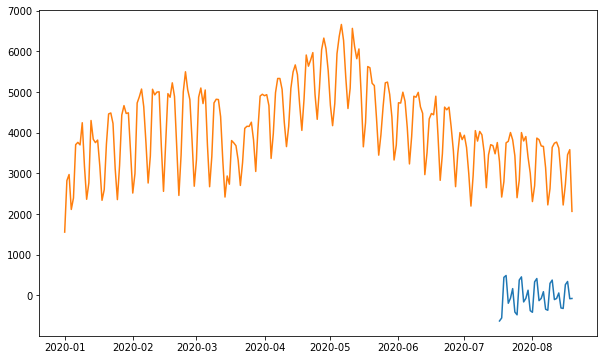

In [44]:
plt.plot(predictions)
plt.plot(nor_df)